# Convolutional Neural Networks with PyTorch Exercise (6 points)

The homework assignment is due by the end of the day on Thursday, November 13.

You are expected to solve the assignment problems independently and adhere to the university's policies for academic honesty and integrity. Copying solutions to the assignment problems from your classmates, the internet, or anywhere else is strictly prohibited.

**Note that your solutions are expected to follow the code examples provided in the lecture notes. If your solution to a problem uses functions or codes that are not covered in the lecture notes, that will result in zero marks assigned for that problem.**

CNNs with PyTorch exercise: 6 points

Total points for Assignment 5: 25 points

In [34]:
import zipfile
import os

zip_path = "/content/Paintings.zip"
extract_dir = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## Part 1. Load the Dataset (1 point)

We will use a subset of the [WikiArt Dataset](https://paperswithcode.com/dataset/wikiart) containing 3,988 paintings by 10 artists. The artists are Cezanne, Degas, Gauguin, Hassam, Matisse, Monet, Pissarro, Renoir, Sargent, and VanGogh.

The file `Paintings.zip` in the `data` directory contains a subdirectory called `images` that contains all 3,988 images, a file `labels.csv` with the labels for all images, and a file `label_names.csv` with the names of the painters that correspond to the labels.

Follow the explanations in Lecture 17 and load the Paintings dataset. During the data loading, resize the images to 224x224 pixels size.

In [35]:
# Your Code Here
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torchvision import transforms

import pandas as pd
import os
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
import natsort
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = "data/Paintings/"
images_dir = os.path.join(data_dir, "images/")
labels_dir = os.path.join(data_dir, "labels.csv")
labels_names_dir = os.path.join(data_dir, "label_names.csv")

image_size = 128

def load_imgs(path):
    # List of all images in the folder
    imgList = listdir(path)
    # Make sure that the images are sorted in ascending order
    imgList=natsort.natsorted(imgList)
    # Number of images
    number_imgs = len(imgList)
    # Initialize numpy arrays for the images
    images = np.zeros((number_imgs, image_size, image_size, 3))
    # Read the images
    for i in range(number_imgs):
        tmp_img = load_img(path + imgList[i], target_size=(image_size, image_size, 3))
        img = img_to_array(tmp_img)
        images[i] = img/255.0
    return images

imgs = load_imgs(images_dir)

Instantiate the train, test, and validation datasets. Use 20% for testing, and 20% of the initial training set for validation. Print the number of samples in the train, test, and validation datasets.

In [36]:
# Your Code Here
image_labels = np.genfromtxt(labels_dir, delimiter=',', dtype=np.int32)
image_label_names = np.genfromtxt(labels_names_dir, delimiter=',', dtype=np.int32)
X_train, X_test, y_train, y_test = train_test_split(imgs, image_labels, test_size=0.2, random_state=42, stratify=image_labels)

print('Training data inputs', X_train.shape)
print('Training labels', X_test.shape)
print('Testing data inputs', y_train.shape)
print('Testing labels', y_test.shape)

Training data inputs (3190, 128, 128, 3)
Training labels (798, 128, 128, 3)
Testing data inputs (3190,)
Testing labels (798,)


Use `DataLoader` to create iterable objects over batches of images and labels for the datasets. Select a batch size of 64 images and labels.

In [37]:
# Your Code Here
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split,TensorDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

class MyDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'images')
        self.labels_file = pd.read_csv(os.path.join(root_dir, 'labels.csv'), header=None)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file.iloc[idx, 0]

        return image, label

dataset = MyDataset(root_dir=data_dir, transform=transform)

# Split the dataset into train and test subsets
train_indices_1, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=123)

# Split the dataset into train and validation subsets
train_indices, val_indices = train_test_split(train_indices_1, test_size=0.2, random_state=123)

# Create training, testing, and validation subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

# Create training, testing, and validation dataloaders for iterating over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

Use the `make_grid()` function to plot images from the training dataset.

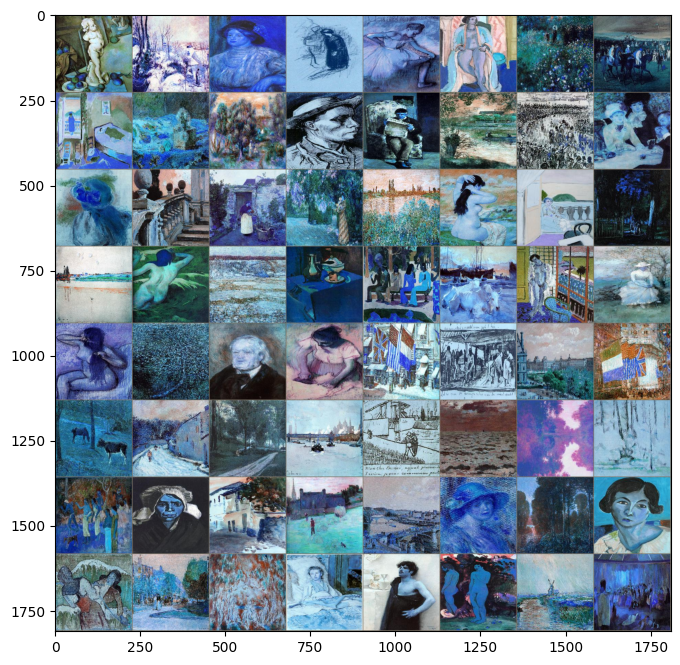

In [45]:
# Your Code Here
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import make_grid

def imshow(img):
  mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

  img = img * std + mean        # un-normalize
  img = img.clamp(0, 1)         # keep values valid for imshow

  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

images, labels = next(iter(train_dataloader))

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

## Part 2. Define the Model (1 point)

Let's use again a pretrained VGG-16 model. Create an instance of the model, e.g., called `model_1` and replace the final layer with a custom layer to output 10 class probabilities.

In [39]:
# Your Code Here
import torch.nn as nn
model_1 = models.vgg16(pretrained=True)
model_1.classifier[-1] = nn.Linear(4096, 10)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Move the model to the GPU device.

In [40]:
# Your Code Here
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)

## Part 3. Train and Evaluate the Model (2 points)

Train the model, plot the learning curves, and evaluate the performance on the test dataset. Use Adam optimizer with 1e-4 learning rate. The expected test accuracy should be around 70%.

Epoch: 1/10	 Training loss: 1.8455	 Training accuracy: 34.914	 Validation accuracy: 40.596
Epoch: 2/10	 Training loss: 1.2227	 Training accuracy: 57.759	 Validation accuracy: 61.285
Epoch: 3/10	 Training loss: 0.7648	 Training accuracy: 74.255	 Validation accuracy: 64.107
Epoch: 4/10	 Training loss: 0.4761	 Training accuracy: 84.013	 Validation accuracy: 65.361
Epoch: 5/10	 Training loss: 0.3052	 Training accuracy: 90.047	 Validation accuracy: 69.592
Epoch: 6/10	 Training loss: 0.1336	 Training accuracy: 95.768	 Validation accuracy: 66.144
Epoch: 7/10	 Training loss: 0.2184	 Training accuracy: 93.260	 Validation accuracy: 71.003
Epoch: 8/10	 Training loss: 0.0867	 Training accuracy: 97.139	 Validation accuracy: 67.241
Epoch: 9/10	 Training loss: 0.0404	 Training accuracy: 98.942	 Validation accuracy: 71.944
Epoch: 10/10	 Training loss: 0.0521	 Training accuracy: 98.472	 Validation accuracy: 70.376
Test dataset accuracy: 68.672


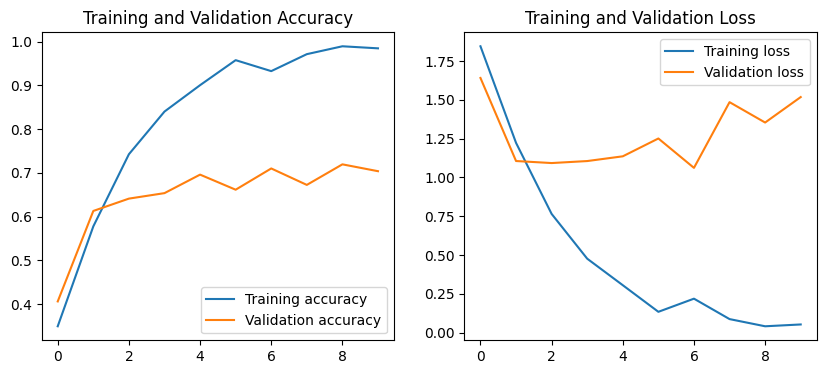

In [41]:
# Your Code Here

# most of this is straight from the lecture notes

# train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train()

    for i, data in enumerate(train_loader):
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        predicted = outputs.argmax(dim=1)
        sum_correct += (predicted == labels).sum().item()
        total += batch_size

    # return the accuracy and loss
    return sum_correct/total, running_loss/total


# evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            predicted = outputs.argmax(dim=1)
            sum_correct += (predicted == labels).sum().item()
            total += batch_size

    # return the accuracy and loss
    return sum_correct/total, running_loss/total

import torch.optim as optim

# define loss function (cross-entropy)
criterion = nn.CrossEntropyLoss()
# define an optimizer (Adam)
optimizer = optim.Adam(model_1.parameters(), lr = 1e-4)

# total number of training epochs
epoch_num = 10

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(model_1, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(model_1, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.4f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

test_accuracy, test_loss = validate(model_1, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()



## Part 4. Train and Evaluate the Model with a Pretrained ResNet50 Model (1 point)

Similarly to the VGG-16 model, import a pretrained ResNet50 model as `model_2`, and afterward train and evaluate the model on the Paintings dataset. Similarly to `model_1` use Adam optimizer with a learning rate of 1e-4. The expected test accuracy should be around 80%.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10	 Training loss: 1.4204	 Training accuracy: 55.643	 Validation accuracy: 73.668
Epoch: 2/10	 Training loss: 0.4105	 Training accuracy: 88.088	 Validation accuracy: 76.489
Epoch: 3/10	 Training loss: 0.0926	 Training accuracy: 98.629	 Validation accuracy: 78.683
Epoch: 4/10	 Training loss: 0.0198	 Training accuracy: 99.922	 Validation accuracy: 80.564
Epoch: 5/10	 Training loss: 0.0111	 Training accuracy: 99.961	 Validation accuracy: 80.564
Epoch: 6/10	 Training loss: 0.0068	 Training accuracy: 100.000	 Validation accuracy: 80.251
Epoch: 7/10	 Training loss: 0.0048	 Training accuracy: 99.961	 Validation accuracy: 81.034
Epoch: 8/10	 Training loss: 0.0046	 Training accuracy: 99.961	 Validation accuracy: 79.937
Epoch: 9/10	 Training loss: 0.0031	 Training accuracy: 99.961	 Validation accuracy: 79.467
Epoch: 10/10	 Training loss: 0.0025	 Training accuracy: 100.000	 Validation accuracy: 81.348
Test dataset accuracy: 79.825


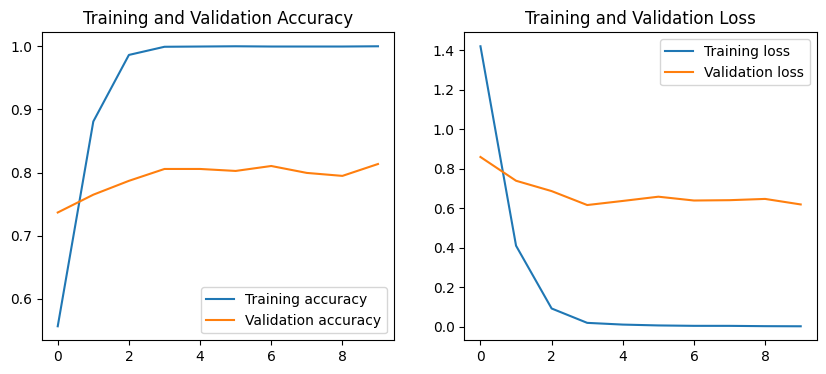

In [42]:
# Your Code Here

'''
Note:
The last layer can be changed to:
model_2.fc = nn.Linear(2048, num_classes)
'''

model_2 = models.resnet50(pretrained=True)
model_2.fc = nn.Linear(2048, 10)
model_2 = model_2.to(device)

optimizer = optim.Adam(model_2.parameters(), lr=1e-4)

# total number of training epochs
epoch_num = 10

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(model_2, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(model_2, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.4f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')


test_accuracy, test_loss = validate(model_2, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

## Part 5. Save and Load the Model Parameters (1 point)

Save the state dictionary for `model_2`.

In [43]:
# Your Code Here
torch.save(model_2.state_dict(), "resnet50_paintings.pth")

Load the state dictionary and evaluate the performance on the test dataset to ensure that the accuracy is the same.

In [44]:
# Your Code Here
loaded_model = models.resnet50(pretrained=False)
loaded_model.fc = nn.Linear(2048, 10)
loaded_model.load_state_dict(torch.load("resnet50_paintings.pth"))
loaded_model = loaded_model.to(device)

test_accuracy, test_loss = validate(loaded_model, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test dataset accuracy: 79.825
